In [1]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # split embed self.heads diff pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)
        
        # einstein sum --> computes the attention scores between q and k for each head across the batch.
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # attention weights u/ each head & each query-key pair
        attention = torch.nn.functional.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

In [3]:
# RESNET50

class HybridModel(nn.Module):
    def __init__(self, num_classes, embed_size, heads):
        super(HybridModel, self).__init__()
        self.cnn = models.resnet50()
        self.cnn.load_state_dict(torch.load('/kaggle/input/resnet50/pytorch/resnet/1/resnet50-0676ba61.pth'))
        
        # Extract the layers up to the last convolutional layer
        self.cnn = nn.Sequential(*(list(self.cnn.children())[:-2]))  # Remove the average pooling and fully connected layers
        
        self.conv1x1 = nn.Conv2d(2048, embed_size, kernel_size=1, stride=1)
        self.relu = nn.ReLU()

        self.self_attention = SelfAttention(embed_size, heads)

        self.classifier = nn.Sequential(
            nn.Linear(embed_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.cnn(x)
        features = self.conv1x1(features)
        features = self.relu(features)
        
        # unpack
        N, C, H, W = features.shape
        features = features.view(N, C, -1).permute(0, 2, 1)  # Reshape to (N, H*W, C)

        attn_output = self.self_attention(features, features, features)
        attn_output = attn_output.permute(0, 2, 1).view(N, C, H, W)  # Reshape back to (N, C, H, W)

        pooled_features = torch.nn.functional.adaptive_avg_pool2d(attn_output, (1, 1)).view(features.size(0), -1)  # Global pooling and flatten
        out = self.classifier(pooled_features)
        return out, features

In [4]:
# Load the model from a saved file path
model_path = '/kaggle/input/skripsibest/pytorch/skripsibest/1/model_epoch_44.pth'

# Load the model directly from the saved file
model_state = torch.load(model_path, map_location=torch.device('cpu'))  # Load onto CPU
model = HybridModel(num_classes=8, embed_size=64, heads=8)  # Instantiate your model
model.load_state_dict(model_state)  # Load the model's state_dict

model.eval()  # Set the model to evaluation mode

HybridModel(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

HybridModel(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 

In [6]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img_bgr = cv2.imread(image_path)  # Load image in BGR format
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_resized = cv2.resize(img_rgb, (224, 224), interpolation=cv2.INTER_CUBIC)  # Resize to 224x224
    img_tensor = transforms.ToTensor()(img_resized).unsqueeze(0)  # Convert to PyTorch tensor
    return img_tensor, img_rgb

In [7]:
# Function to perform occlusion sensitivity
def occlusion_sensitivity(model, image_tensor, target_class=None, occlusion_size=25, occlusion_stride=5):
    model.eval()
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)
    
    # Detach image to make it a leaf tensor and set requires_grad
    image_tensor = image_tensor.detach().clone()
    image_tensor.requires_grad = True

    with torch.no_grad():
        predictions, _ = model(image_tensor)

    if target_class is None:
        target_class = torch.argmax(predictions, dim=1).item()

    base_score = predictions[:, target_class].cpu().detach().numpy()

    _, _, H, W = image_tensor.shape
    heatmap = np.zeros((H, W))

    for y in range(0, H, occlusion_stride):
        for x in range(0, W, occlusion_stride):
            # occluded image
            occluded_image = image_tensor.clone()
            occluded_image[:, :, y:y+occlusion_size, x:x+occlusion_size] = 0

            with torch.no_grad():
                output, _ = model(occluded_image)
            score = output[:, target_class].cpu().detach().numpy()

            # score
            heatmap[y:y+occlusion_size, x:x+occlusion_size] = base_score - score

    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    # Gaussian smoothing
    heatmap = cv2.GaussianBlur(heatmap, (5, 5), 0)  # Increased the kernel size for more smoothing

    return heatmap

In [10]:
# visualize occlusion sensitivity
def visualize_occlusion(model, img_path):
    image_tensor, original_image = load_and_preprocess_image(img_path)
    device = next(model.parameters()).device

    model.eval()
    with torch.no_grad():
        preds, _ = model(image_tensor.to(device))
    target_class_idx = preds.argmax().item()

    heatmap = occlusion_sensitivity(model, image_tensor, target_class_idx)

    heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_LINEAR)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    plt.colorbar(label='Heatmap Values', fraction=0.046, pad=0.04, alpha=0.5)
    plt.title('Occlusion Sensitivity Heatmap')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_34/424767667.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Heatmap Values', fraction=0.046, pad=0.04, alpha=0.5)


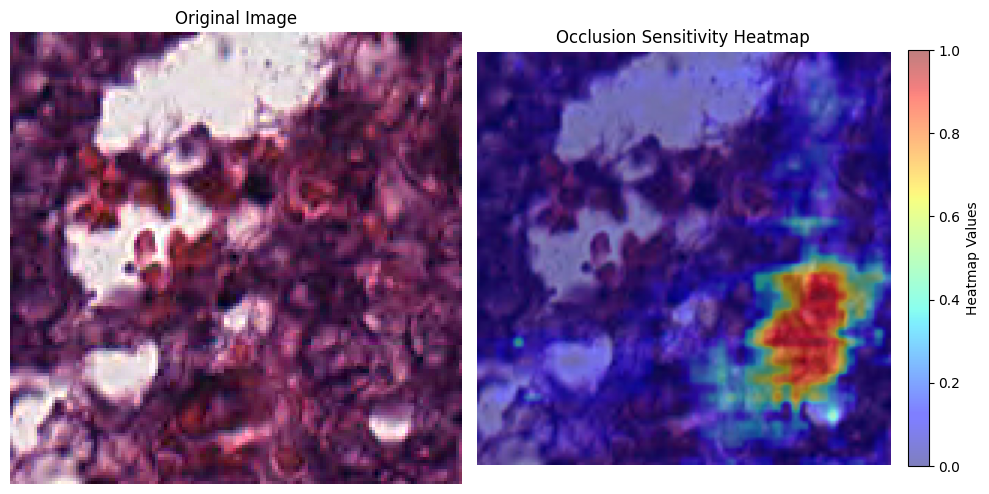

In [34]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/01_TUMOR/1021F_CRC-Prim-HE-04_029.tif_Row_151_Col_1.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

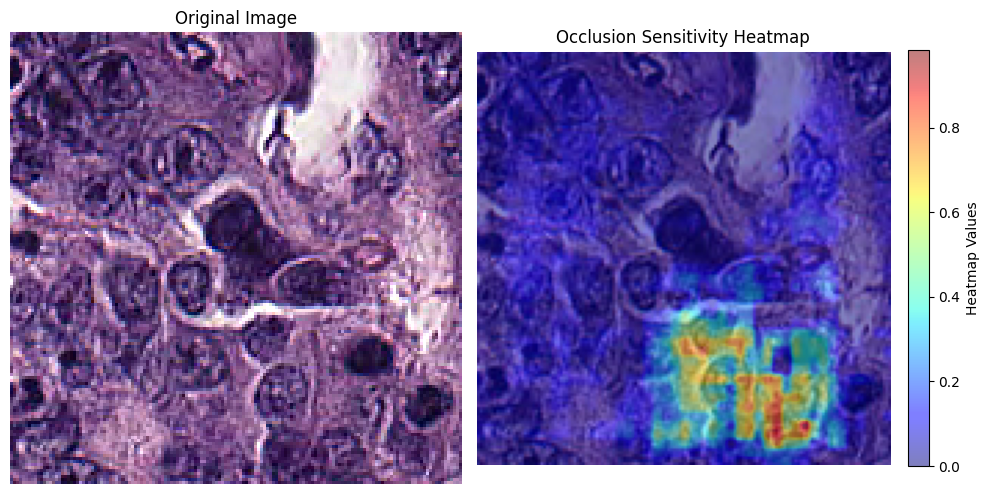

In [11]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/01_TUMOR/6C45_CRC-Prim-HE-02_028.tif_Row_601_Col_1.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

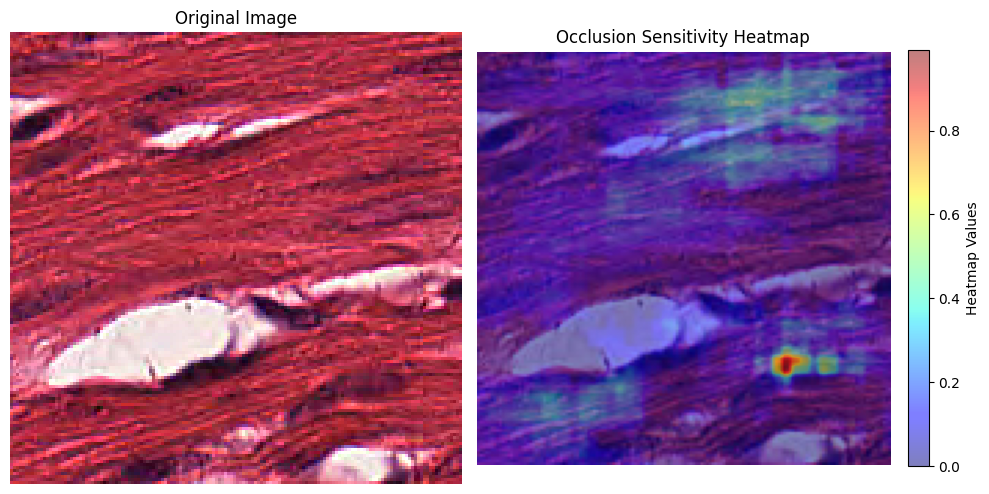

In [12]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/02_STROMA/102DB_CRC-Prim-HE-01_018.tif_Row_1_Col_301.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

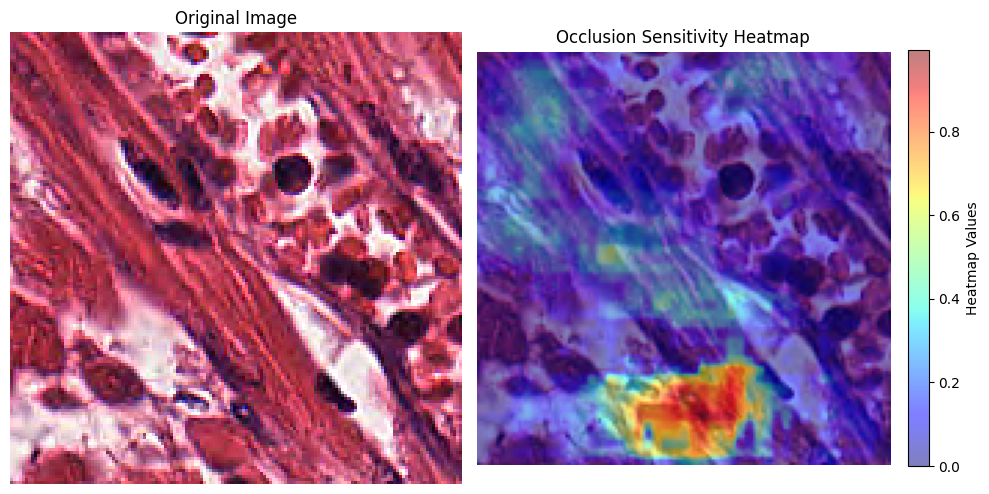

In [13]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/02_STROMA/10A94_CRC-Prim-HE-10_019.tif_Row_751_Col_1801.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

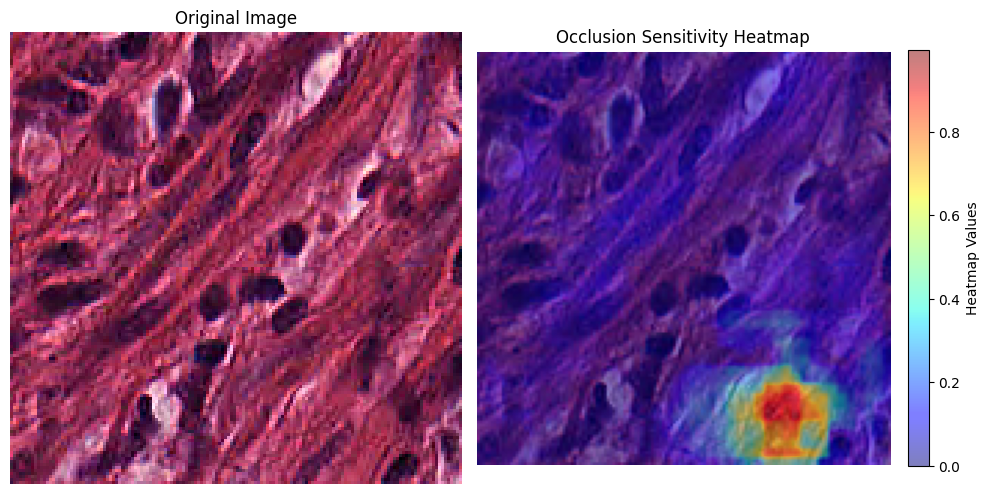

In [14]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/03_COMPLEX/108FE_CRC-Prim-HE-08_005.tif_Row_151_Col_1.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

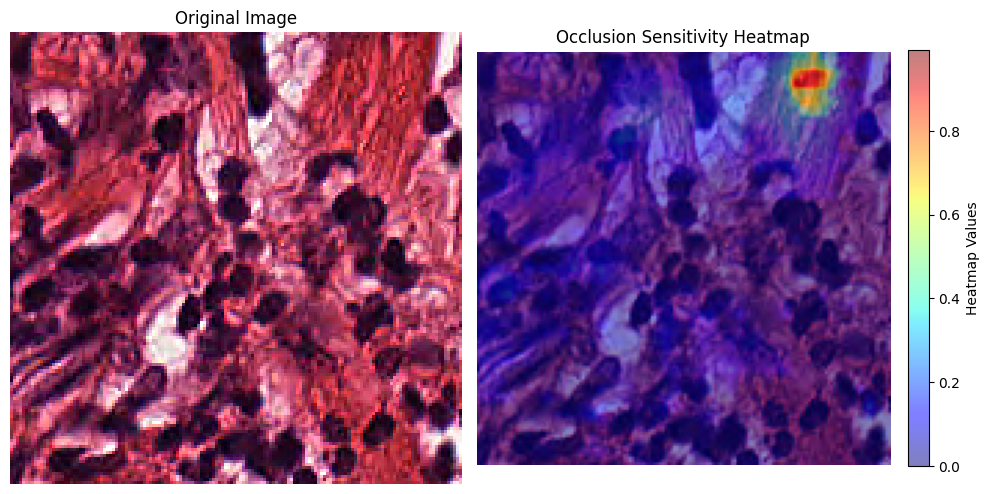

In [15]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/03_COMPLEX/1C09_CRC-Prim-HE-01_035.tif_Row_151_Col_1201.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

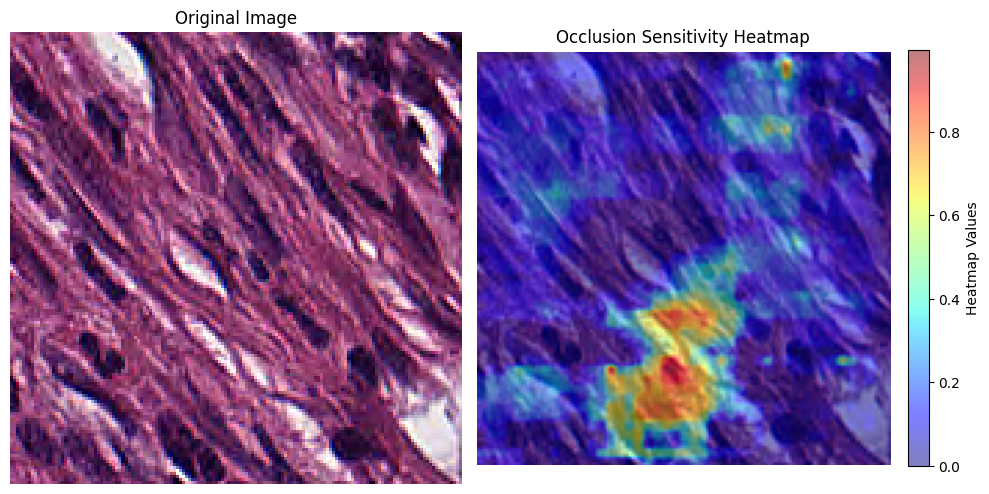

In [16]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/04_LYMPHO/1283D_CRC-Prim-HE-09_008.tif_Row_1_Col_1501.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

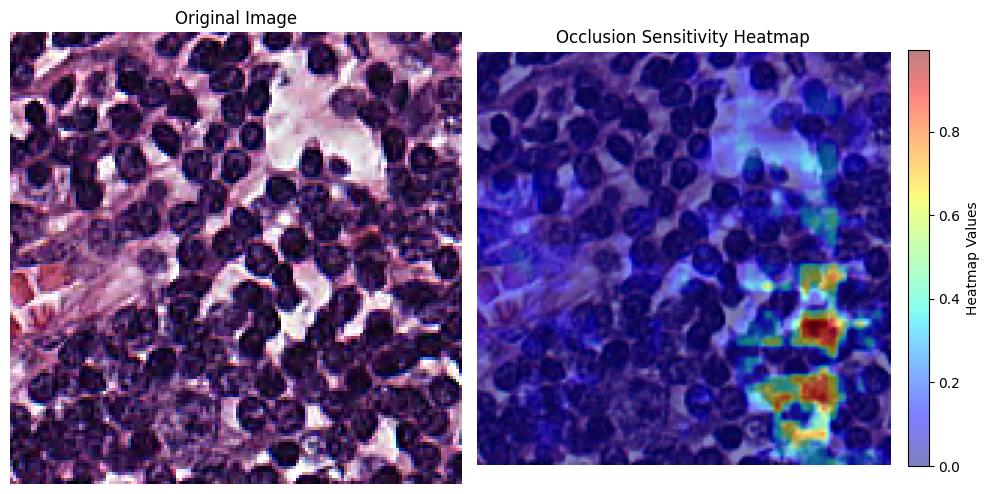

In [17]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/04_LYMPHO/1F89_CRC-Prim-HE-05_010.tif_Row_1201_Col_151.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

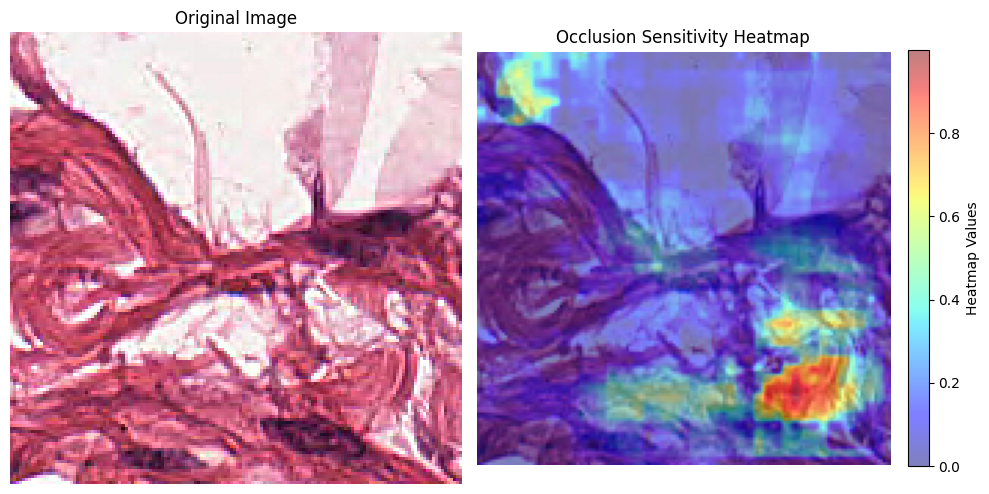

In [18]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/05_DEBRIS/1087B_CRC-Prim-HE-07_002.tif_Row_1201_Col_1201.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

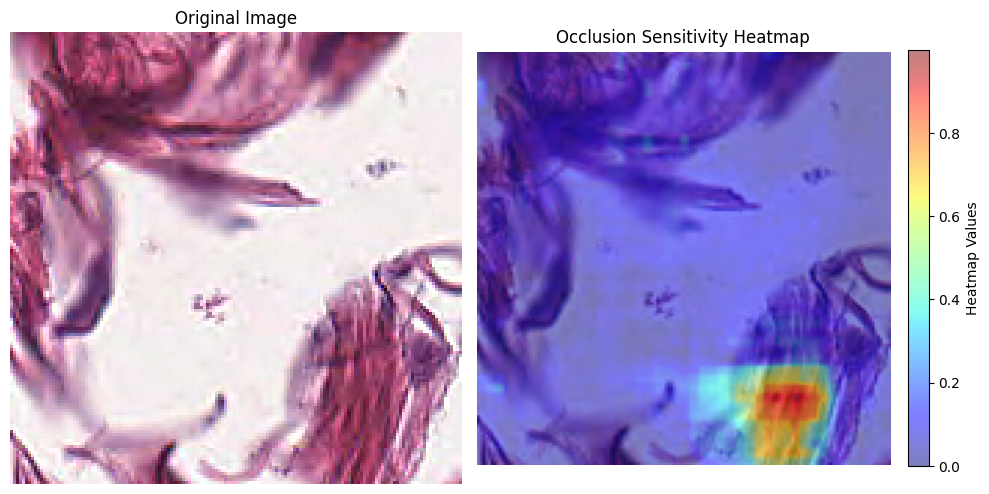

In [19]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/05_DEBRIS/3A21_CRC-Prim-HE-08_023.tif_Row_451_Col_451.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

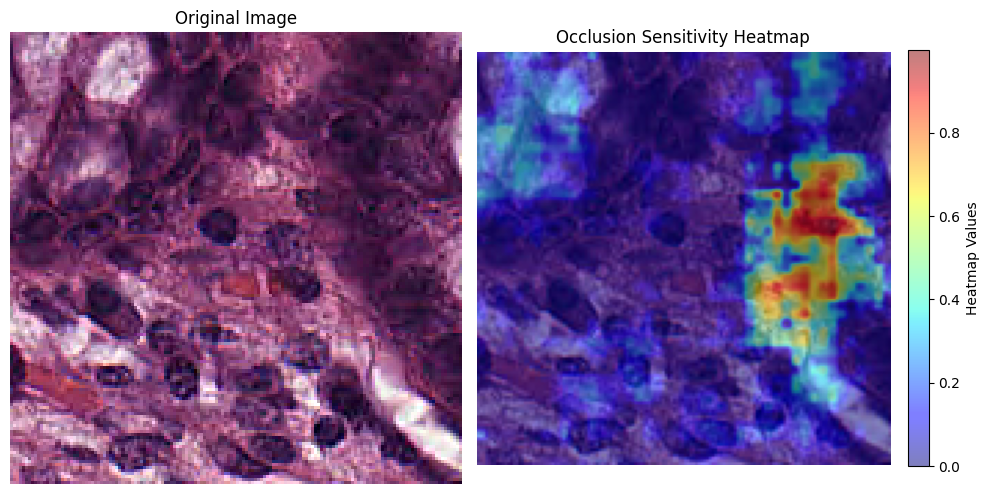

In [20]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/06_MUCOSA/10764_CRC-Prim-HE-06_032.tif_Row_1_Col_901.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

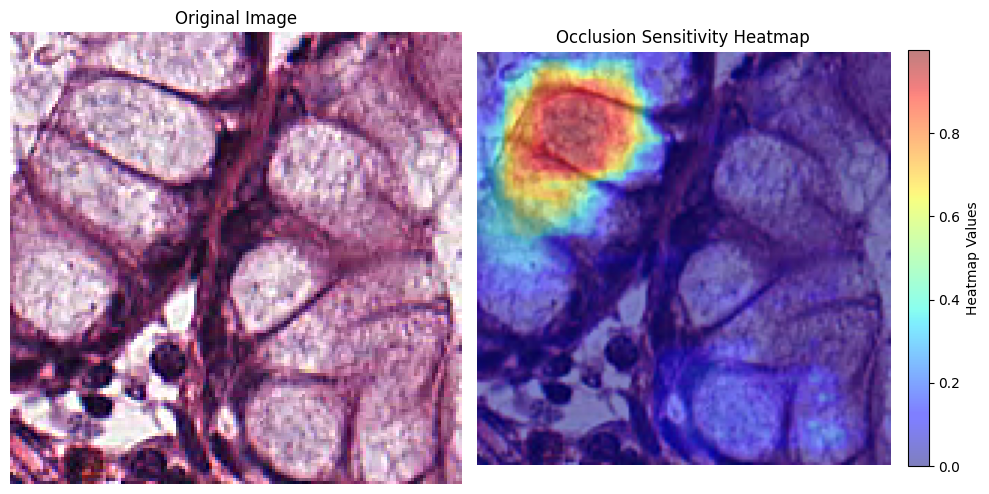

In [21]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/06_MUCOSA/1CF1_CRC-Prim-HE-03_006.tif_Row_1651_Col_901.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

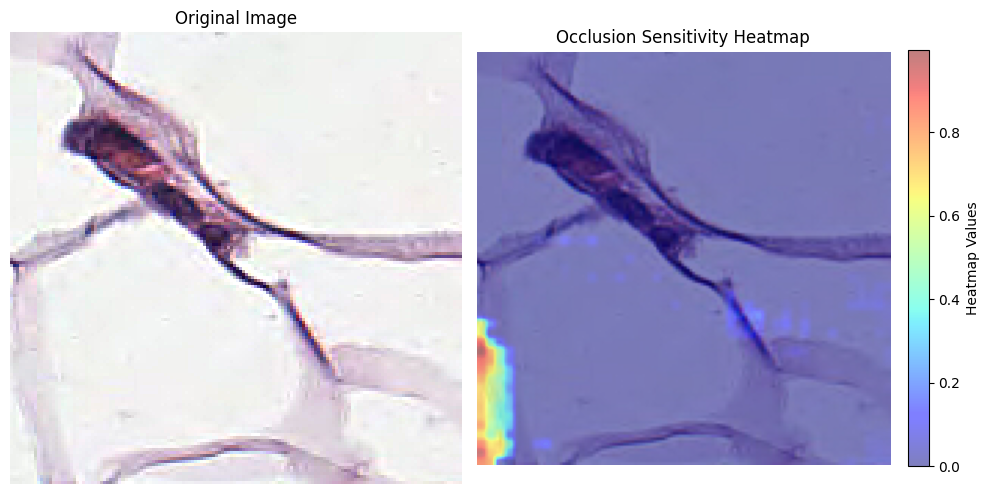

In [22]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/07_ADIPOSE/104E9_CRC-Prim-HE-05_032.tif_Row_1051_Col_4351.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

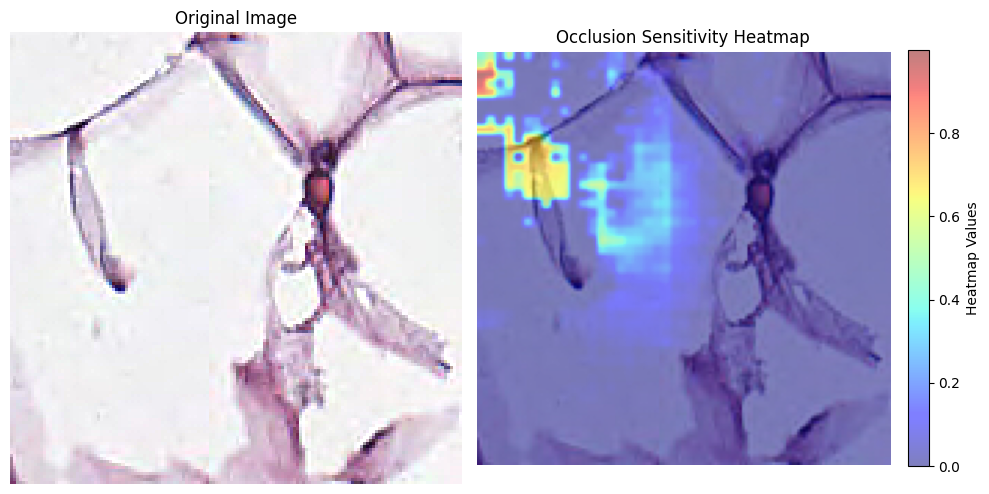

In [23]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/07_ADIPOSE/10CB3_CRC-Prim-HE-03_012.tif_Row_151_Col_451.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

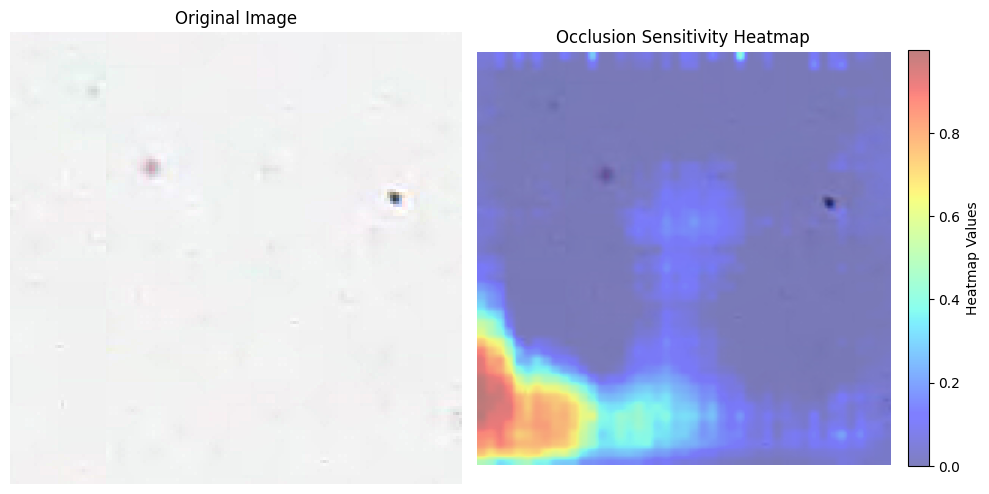

In [24]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/08_EMPTY/10433_CRC-Prim-HE-06_005.tif_Row_4351_Col_2701.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

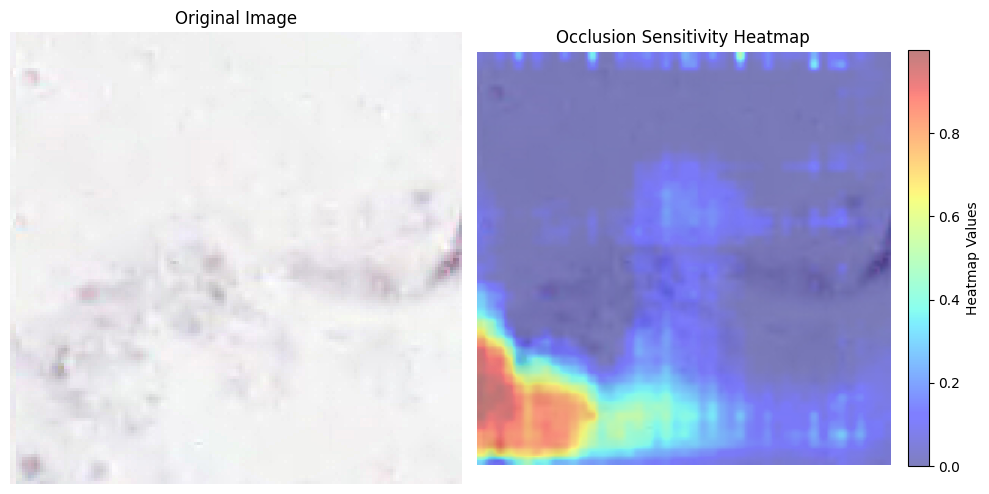

In [25]:
# Load and preprocess the image
image_path = '/kaggle/input/enhanced-sharp/08_EMPTY/10B24_CRC-Prim-HE-06_005.tif_Row_4351_Col_3451.tif'

# Visualize occlusion sensitivity
visualize_occlusion(model, image_path)

In [ ]:
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img_bgr = cv2.imread(image_path)  # Load image in BGR format
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_resized = cv2.resize(img_rgb, (224, 224), interpolation=cv2.INTER_CUBIC)  # Resize to 224x224
    img_tensor = transforms.ToTensor()(img_resized).unsqueeze(0)  # Convert to PyTorch tensor
    return img_tensor, img_rgb

In [6]:
def occlusion_sensitivity(model, image_tensor, target_class=None, occlusion_size=25, occlusion_stride=5):
    model.eval()
    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)
    
    # Detach image to make it a leaf tensor and set requires_grad
    image_tensor = image_tensor.detach().clone()
    image_tensor.requires_grad = True

    with torch.no_grad():
        predictions, _ = model(image_tensor)

    if target_class is None:
        target_class = torch.argmax(predictions, dim=1).item()

    base_score = predictions[:, target_class].cpu().detach().numpy()

    _, _, H, W = image_tensor.shape
    heatmap = np.zeros((H, W))

    for y in range(0, H, occlusion_stride):
        for x in range(0, W, occlusion_stride):
            # Create occluded image
            occluded_image = image_tensor.clone()
            occluded_image[:, :, y:y+occlusion_size, x:x+occlusion_size] = 0

            with torch.no_grad():
                output, _ = model(occluded_image)
            score = output[:, target_class].cpu().detach().numpy()

            # Compute difference in score
            heatmap[y:y+occlusion_size, x:x+occlusion_size] = base_score - score

    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)

    # Apply Gaussian smoothing to the heatmap
    heatmap = cv2.GaussianBlur(heatmap, (11, 11), 0)

    return heatmap

In [9]:
# Load and preprocess the image
# /kaggle/input/enhanced-sharp/01_TUMOR
image_path = '/kaggle/input/enhanced-sharp/01_TUMOR/1021F_CRC-Prim-HE-04_029.tif_Row_151_Col_1.tif'
image_tensor, original_image = load_and_preprocess_image(image_path)

In [12]:
# Load your original image
original_image = cv2.imread(image_path)  # Replace 'image_path' with your image path

# Load the occlusion sensitivity heatmap
heatmap = occlusion_sensitivity(model, image_tensor, target_class=None)

# Normalize the heatmap for visualization
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)

# Resize the heatmap to match the original image dimensions
heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

# Apply colormap (Jet) to the heatmap
heatmap_jet = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_jet, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(heatmap_jet, 0.4, original_image, 0.6, 0)

/tmp/ipykernel_34/768872814.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Heatmap Values', fraction=0.046, pad=0.04)
/tmp/ipykernel_34/768872814.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Heatmap Values', fraction=0.046, pad=0.04)


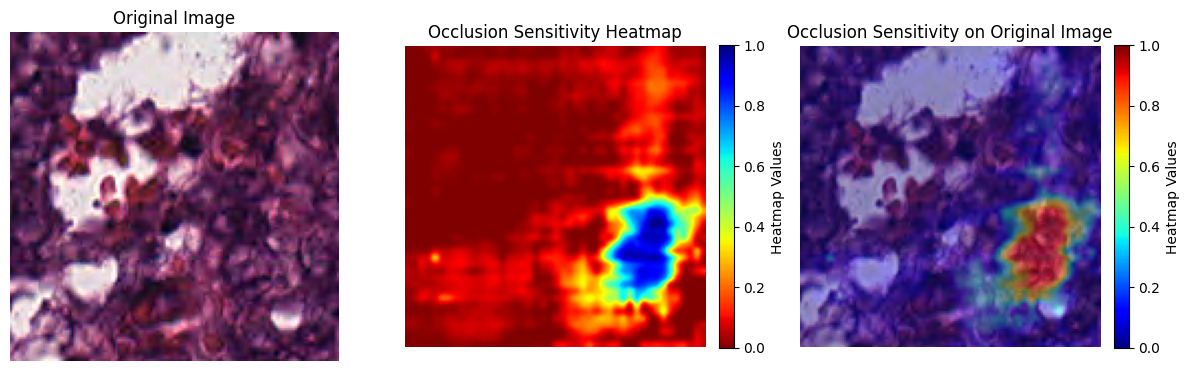

In [13]:
import matplotlib.pyplot as plt
import cv2  # assuming cv2 is imported elsewhere for image manipulation
import matplotlib.colors as mcol
import matplotlib.cm as cm

# Visualize the result
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Occlusion Sensitivity Heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap_jet, interpolation='lanczos')
plt.title('Occlusion Sensitivity Heatmap')
plt.axis('off')
sm = plt.cm.ScalarMappable(cmap='jet_r', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, label='Heatmap Values', fraction=0.046, pad=0.04)

# Superimposed Image
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Occlusion Sensitivity on Original Image')
plt.axis('off')
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, label='Heatmap Values', fraction=0.046, pad=0.04)


plt.tight_layout()
plt.show()